In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import wordnet
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

def is_count(tag):
    return is_noun(tag) or is_verb(tag) or is_adverb(tag) or is_adjective(tag)

In [13]:
df = pd.read_table('./Emobank-master/corpus/raw.tsv')

tokens = []
for index, row in df.iterrows():
#     w_list = p.findall(row['sentence'])
    w_list = nltk.word_tokenize(row['sentence'])
    tokens.append(w_list)

from itertools import chain
tokens = list(chain.from_iterable(tokens))
# 重複を除く
tokens = list(set(tokens))

# lower(小文字)の出現単語
l_tokens = [w.lower() for w in tokens]
nltk_tokens = nltk.pos_tag(l_tokens)

# 三単元,複数などを正規化
reg_tokens = []
for token in nltk_tokens:
    if wordnet.morphy(token[0]) is not None:
        word = wordnet.morphy(token[0])
    else:
        word = token[0]
    if is_count(token[1]):
        reg_tokens.append(word)

reg_tokens = list(set(reg_tokens))
vec_size = len(reg_tokens)
vec_size

13299

In [14]:
def extract_word(s, debug=False):
    # 文章から出現単語を抜き出す
    res = np.zeros(vec_size)
    word_list = nltk.word_tokenize(s)
    if debug:
        cnt_words = []
    for w in word_list:
        if wordnet.morphy(w) is not None:
            word = wordnet.morphy(w)
        else:
            word = w
        if w in reg_tokens:
            # 単語が出現する
            ind = reg_tokens.index(w)
            if debug:
                cnt_words.append(w)
            res[ind] += 1
    if debug:
        print(cnt_words)
        
    return res

In [15]:
data_vad = pd.read_table('./Emobank-master/corpus/reader.tsv')
# sentence<->vadのいずれかがないデータを消す
merged_data = pd.merge(df,data_vad,on='id')

In [17]:
X_orig = np.array([ extract_word(row['sentence']) for index,row in merged_data.iterrows() ])
Y_a = merged_data['Arousal'].as_matrix()
Y_v = merged_data['Valence'].as_matrix()
Y_d = merged_data['Dominance'].as_matrix()
Y_orig = np.c_[Y_v,Y_a,Y_d]

In [18]:
a=1
b=5
Y_orig = (2*(Y_orig-a)/(b-a))-1
# [-1,1]で正規化
print(Y_orig.min(),Y_orig.max())

-1.0 1.0


In [19]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [20]:
X = X_orig
Y = Y_orig

In [21]:
def train_and_test(net,X,Y,learning_rate = 0.1,epochs = 500,batch_size = 1000,test_size = 0.2):

    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=test_size)

    #Loss関数の指定
    criterion = nn.MSELoss()
    #Optimizerの指定
    optimizer=optim.Adam(net.parameters(),lr=learning_rate)

    X_plot = []
    Y_plot = []
    Y_test_plot = []
    
    x_test = Variable(torch.FloatTensor(test_X))
    y_test = Variable(torch.FloatTensor(test_Y))

    n_batch = int(len(train_X)/batch_size)

    for epoch in range(epochs):
        # Forward pass: Compute predicted y by passing x to the model
    #     loss_sum = 0
        train_X, train_Y = shuffle(train_X, train_Y)
        for i in range(n_batch+1):
            start = i*batch_size
            end = start + batch_size
            x = Variable(torch.FloatTensor(train_X[start:end]))
            y = Variable(torch.FloatTensor(train_Y[start:end]))
            y_pred = net(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    #         loss_sum += loss.data[0].item()

        if epoch % 20 == 0:
            X_plot.append(epoch)
            Y_plot.append(loss.data[0].item())
            
            y_test_pred = net(x_test)
            loss_test = criterion(y_test_pred,y_test)
            Y_test_plot.append(loss_test[0].item())
    
            print("epoch : {0} , loss : {1}".format(epoch,loss.data[0].item()))


    p1, = plt.plot(X_plot, Y_plot)
    p2, = plt.plot(X_plot, Y_test_plot)
    plt.legend([p1,p2],["train","test"])
    plt.show()
    
#     print("loss {0}".format(loss_test))
    return net

In [66]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(vec_size,3)
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [ ]:
net1 = Net1()
net1 = train_and_test(net1,X,Y,epochs=100,batch_size=vec_size)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch : 0 , loss : 0.031494010239839554


In [103]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(vec_size,100)
        self.fc2 = nn.Linear(100,3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x
    
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(vec_size,1000)
        self.fc2 = nn.Linear(1000,3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch : 0 , loss : 0.03210810199379921
epoch : 20 , loss : 0.027340231463313103
epoch : 40 , loss : 0.02533813938498497
epoch : 60 , loss : 0.024949541315436363
epoch : 80 , loss : 0.024630920961499214


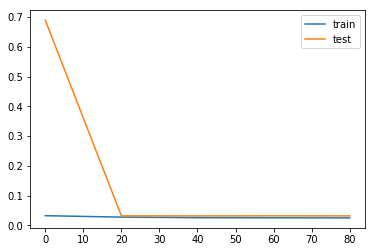

epoch : 0 , loss : 0.03185103461146355
epoch : 20 , loss : 0.9300661683082581
epoch : 40 , loss : 0.9575667977333069
epoch : 60 , loss : 0.958686351776123
epoch : 80 , loss : 0.9606229066848755


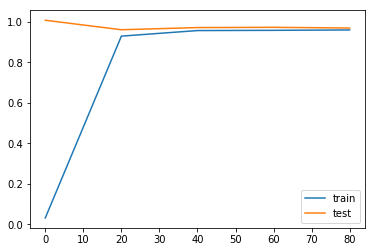

[[0.03185103461146355,
  0.9300661683082581,
  0.9575667977333069,
  0.958686351776123,
  0.9606229066848755],
 [1.0085572004318237,
  0.961591899394989,
  0.9723699688911438,
  0.9734905362129211,
  0.9702014327049255]]

In [104]:
net2 = Net2()
train_and_test(net2,X,Y,epochs=100,batch_size=vec_size)
net3 = Net3()
train_and_test(net3,X,Y,epochs=100,batch_size=vec_size)

In [61]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(vec_size,1000)
        self.fc2 = nn.Linear(1000,100)
        self.fc3 = nn.Linear(100,3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x
    

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch : 0 , loss : 0.03375084325671196
epoch : 20 , loss : 1.0380572080612183
epoch : 40 , loss : 1.0380572080612183
epoch : 60 , loss : 1.0380572080612183
epoch : 80 , loss : 1.0380572080612183


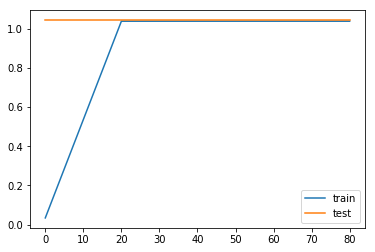

[[0.03375084325671196,
  1.0380572080612183,
  1.0380572080612183,
  1.0380572080612183,
  1.0380572080612183],
 [1.0430110692977905,
  1.0430110692977905,
  1.0430110692977905,
  1.0430110692977905,
  1.0430110692977905]]

In [62]:
net4 = Net4()
train_and_test(net4,X,Y,epochs=100,batch_size=vec_size)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch : 0 , loss : 0.03497263044118881
epoch : 20 , loss : 0.030298607423901558
epoch : 40 , loss : 0.02820812165737152
epoch : 60 , loss : 0.027370136231184006
epoch : 80 , loss : 0.02573726326227188
epoch : 100 , loss : 0.023480422794818878
epoch : 120 , loss : 0.02257777377963066
epoch : 140 , loss : 0.022138457745313644
epoch : 160 , loss : 0.021906297653913498
epoch : 180 , loss : 0.021726418286561966
epoch : 200 , loss : 0.02165847457945347
epoch : 220 , loss : 0.021617073565721512
epoch : 240 , loss : 0.02158391661942005
epoch : 260 , loss : 0.021561335772275925
epoch : 280 , loss : 0.021543040871620178
epoch : 300 , loss : 0.02153060771524906
epoch : 320 , loss : 0.02150503545999527
epoch : 340 , loss : 0.021508611738681793
epoch : 360 , loss : 0.021493760868906975
epoch : 380 , loss : 0.0214875265955925
epoch : 400 , loss : 0.021508801728487015
epoch : 420 , loss : 0.021467989310622215
epoch : 440 , loss : 0.021464858204126358
epoch : 460 , loss : 0.02146657183766365
epoch : 4

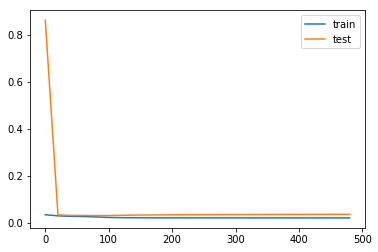

[[0.03497263044118881,
  0.030298607423901558,
  0.02820812165737152,
  0.027370136231184006,
  0.02573726326227188,
  0.023480422794818878,
  0.02257777377963066,
  0.022138457745313644,
  0.021906297653913498,
  0.021726418286561966,
  0.02165847457945347,
  0.021617073565721512,
  0.02158391661942005,
  0.021561335772275925,
  0.021543040871620178,
  0.02153060771524906,
  0.02150503545999527,
  0.021508611738681793,
  0.021493760868906975,
  0.0214875265955925,
  0.021508801728487015,
  0.021467989310622215,
  0.021464858204126358,
  0.02146657183766365,
  0.021465659141540527],
 [0.863288164138794,
  0.03438365086913109,
  0.03218773379921913,
  0.031977009028196335,
  0.0313732773065567,
  0.031655412167310715,
  0.03259345144033432,
  0.03334380313754082,
  0.03391040489077568,
  0.03433016315102577,
  0.034933075308799744,
  0.03514530509710312,
  0.03535521402955055,
  0.035557955503463745,
  0.035658400505781174,
  0.035841334611177444,
  0.036000240594148636,
  0.03620408475

In [63]:
net2 = Net2()
train_and_test(net2,X,Y,epochs=500,batch_size=vec_size)

In [22]:
def sentence_to_vad(s, model):
    x = extract_word(s,debug=True)
    x = torch.FloatTensor(x)
    y_pred = model(x)
    y_pred = y_pred.data.numpy()
    res = {
        'valence' : y_pred[0],
        'arousal'  : y_pred[1],
        'dominance' : y_pred[2]
    }
    return res

In [124]:
s = "Im very happy to see you."
print(sentence_to_vad(s,net2))
s = "happy happy happy happy happy"
print(sentence_to_vad(s,net2))
s = "Im very angry, fucking you"
print(sentence_to_vad(s,net2))
s = "fuck fuck fuck"
print(sentence_to_vad(s,net2))

['very', 'happy', 'see']
{'valence': -0.0006112146, 'arousal': 0.011943448, 'dominance': 0.032359146}
['happy', 'happy', 'happy', 'happy', 'happy']
{'valence': 0.43180105, 'arousal': 0.99452513, 'dominance': 0.64152306}
['very', 'angry', 'fucking']
{'valence': -0.0006112146, 'arousal': 0.011943448, 'dominance': 0.032359146}
['fuck', 'fuck', 'fuck']
{'valence': -0.9772021, 'arousal': 0.95645165, 'dominance': -0.9416526}


In [23]:
import re

In [31]:
def make_word_vector(lb):
    # lb以上の出現回数の言葉を数える
    
    p = re.compile(r'[A-Za-z][A-Za-z\'0-9]*')
    df = pd.read_table('./Emobank-master/corpus/raw.tsv')
    tokens = []
    for index, row in df.iterrows():
        w_list = p.findall(row['sentence'])
    #     w_list = nltk.word_tokenize(row['sentence'])
        for w in w_list:
            if wordnet.morphy(w) is not None:
                word = wordnet.morphy(w)
            else:
                word = w
            tokens.append(word)

    # lowerにする,stopwordsを除く
    stopwords = nltk.corpus.stopwords.words('english')
    symbols = ["'", '"', '`', '.', ',', '-', '!', '?', ':', ';', '(', ')']

    lower_tokens = [w.lower() for w in tokens if w.lower() not in stopwords+symbols]


    nltk_tokens = nltk.pos_tag(lower_tokens)

    reg_tokens = []
    for token in nltk_tokens:
        if is_count(token[1]):
            reg_tokens.append(token[0])

    text = nltk.Text(reg_tokens)
    clean_fdist = nltk.FreqDist(w for w in text)

    extracted_word_list = [key for key,val in clean_fdist.items() if val >= lb]
    return extracted_word_list

In [163]:
word_vec_10 = make_word_vector(10)
len(word_vec_10)

1942

In [25]:
def extract_word_from_word_vec (s,word_vec,debug=False):
    res = np.zeros(len(word_vec))
    word_list = nltk.word_tokenize(s)
    if debug:
        count_word = []
    for w in word_list:
        if wordnet.morphy(w) is not None:
            word = wordnet.morphy(w)
        else:
            word = w
        if w in word_vec:
            # 単語が出現する
            if debug:
                count_word.append(word)
            ind = word_vec.index(w)
            res[ind] += 1
    if debug:
        print(count_word)
    return res

In [33]:
def make_dat_from_word_vec(word_vec):
    data_vad = pd.read_table('./Emobank-master/corpus/reader.tsv')
    # sentence<->vadのいずれかがないデータを消す
    merged_data = pd.merge(df,data_vad,on='id')
    X_orig = np.array([ extract_word_from_word_vec(row['sentence'],word_vec)\
                       for index,row in merged_data.iterrows()])
    Y_a = merged_data['Arousal'].as_matrix()
    Y_v = merged_data['Valence'].as_matrix()
    Y_d = merged_data['Dominance'].as_matrix()
    Y_orig = np.c_[Y_v,Y_a,Y_d]
    a=1
    b=5
    Y_orig = (2*(Y_orig-a)/(b-a))-1
    # [-1,1]で正規化
    return X_orig,Y_orig

In [ ]:
X,Y = make_dat_from_word_vec(word_vec_10)

In [ ]:
vec_size_10 = len(word_vec_10)

In [27]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(vec_size_10,100)
        self.fc2 = nn.Linear(100,3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch : 0 , loss : 0.043375786393880844
epoch : 20 , loss : 0.029551586136221886
epoch : 40 , loss : 0.027289187535643578
epoch : 60 , loss : 0.025073442608118057
epoch : 80 , loss : 0.02696460299193859


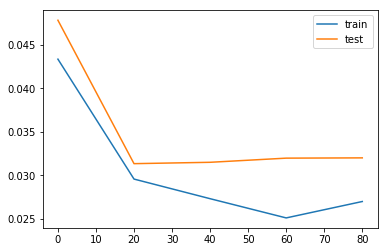

In [183]:
net4 = Net4()
net4 = train_and_test(net4,X,Y,epochs=100,batch_size=vec_size_10)

In [28]:
def sentence_to_vad_from_word_vector(s, model,word_vec):
    x = extract_word_from_word_vec(s,word_vec,debug=True)
    x = torch.FloatTensor(x)
    y_pred = model(x)
    y_pred = y_pred.data.numpy()
    res = {
        'valence' : y_pred[0],
        'arousal'  : y_pred[1],
        'dominance' : y_pred[2]
    }
    return res

In [ ]:
s = "Im very happy to see you."
print(sentence_to_vad_from_word_vector(s,net4,word_vec_10))
s = "happy happy happy happy happy"
print(sentence_to_vad_from_word_vector(s,net4,word_vec_10))
s = "Im very angry, fucking you"
print(sentence_to_vad_from_word_vector(s,net4,word_vec_10))
s = "fuck fuck fuck"
print(sentence_to_vad_from_word_vector(s,net4,word_vec_10))


In [29]:
def sentences_to_vad(sentences,net,word_vec):
    for s in sentences:
        print(sentence_to_vad_from_word_vector(s,net,word_vec))

In [ ]:
store_models = {}

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch : 0 , loss : 0.03402981534600258
epoch : 20 , loss : 0.02419661357998848
epoch : 40 , loss : 0.02176523581147194
epoch : 60 , loss : 0.02120327018201351
epoch : 80 , loss : 0.020992359146475792
epoch : 100 , loss : 0.020721953362226486
epoch : 120 , loss : 0.020590221509337425
epoch : 140 , loss : 0.020376024767756462
epoch : 160 , loss : 0.020260140299797058
epoch : 180 , loss : 0.020172081887722015


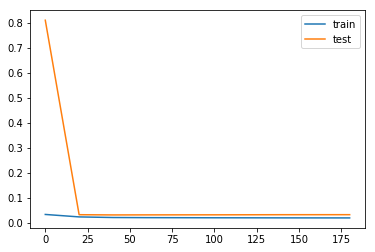

select_lower_bound = 1
['happy', 'see']
{'valence': -0.005538596, 'arousal': -0.0015600768, 'dominance': 0.031416606}
['happy', 'happy', 'happy', 'happy', 'happy']
{'valence': 0.98607874, 'arousal': 0.80336744, 'dominance': 0.7414084}
['fine', 'thank']
{'valence': -0.005538596, 'arousal': -0.0015600768, 'dominance': 0.031416606}
['sad', 'angry', 'rain']
{'valence': -0.7533466, 'arousal': 0.20827648, 'dominance': -0.44684154}


NameError: name 'store_models' is not defined

In [34]:
attempts = [1,2,3,4,5,7,10]
sentences = [
    "Im very happy and excited to see you.",
    "happy happy happy happy happy",
    "Im fine thank you",
    "sad angry rain "
]

for i in attempts:
    lb = i
    selected_word_vec = make_word_vector(lb)
    selected_vec_size = len(selected_word_vec)
    X,Y = make_dat_from_word_vec(selected_word_vec)

    class SelectedNet(nn.Module):
        def __init__(self):
            super(SelectedNet, self).__init__()
            self.fc1 = nn.Linear(selected_vec_size,100)
            self.fc2 = nn.Linear(100,3)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.tanh(self.fc2(x))
            return x

    s_net = SelectedNet()
    s_net = train_and_test(s_net,X,Y,epochs=200,batch_size=selected_vec_size)
    
    print("select_lower_bound = {0}".format(lb ))
    sentences_to_vad(sentences,s_net,selected_word_vec)
    
    store_models.update({
        lb : s_net
    })